# GLM Model : Pure Premium Model 

#### Use SKlearn API : Poisson and Gamma Regression

Multi-variate Model 01 : Frequency-Severity Method

1.Model with cgroup, tgroup

2.Model without Annual Milage as a Predictor

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

## Part 1 : Training Data

### Read Data

In [4]:
data = pd.read_csv('data_purepremium_train.csv')

In [5]:
data.head(3)

,pol_id,ann_miles,rateclass,cgroup,tgroup,TotLoss,ClaimNum,EarnExpo
0,3222855,14831.0,1,A,5,0,0,1.000000
1,2650451,4789.0,1,A,4,0,0,0.666667
2,1400104,2994.0,1,A,4,0,0,1.000000


In [6]:
data.shape

(99947, 8)

###  Process Data

Filter Total Loss 

In [7]:
print( 'ClaimNumber before processing :', np.sum( data.ClaimNum>0) )
print(data.groupby(by=['ClaimNum']).size().values )

_TotLoss_ = data.apply( lambda x : 0.0 if x.TotLoss<50.0 else x.TotLoss, axis=1 )
data['TotLoss']  = _TotLoss_ 

_ClaimNum_ = data.apply( lambda x : 0.0 if x.TotLoss==0.0 else x.ClaimNum, axis=1 )
data['ClaimNum'] = _ClaimNum_

print( 'ClaimNumber after processing  :', np.sum( data.ClaimNum>0) )
print( data.groupby(by=['ClaimNum']).size().values )

ClaimNumber before processing : 4302
[95645  4117   178     7]
ClaimNumber after processing  : 4125
[95822  3942   176     7]


Check Agrregate Risks  

In [8]:
print( 'Claim Frequency :', round(data.ClaimNum.sum()/data.EarnExpo.sum(),4) ) 
print( 'Claim Severity  :', round(data.TotLoss.sum()/data.ClaimNum.sum(),2) ) 
print( 'Pure Premium    :', round( data.TotLoss.sum()/data.EarnExpo.sum(),2) ) 

Claim Frequency : 0.0496
Claim Severity  : 2954.24
Pure Premium    : 146.54


Select  Columns

In [9]:
df = data[['ann_miles','cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

One-hot Encoding

In [10]:
# pd.CategoricalIndex(df.cgroup)

In [11]:
# pd.CategoricalIndex(df.tgroup)

In [12]:
# pd.CategoricalIndex(df.rateclass)

In [16]:
def relevel(data, feature_name, base_level):
    
    if data[feature_name].dtype=='int':
        feature = data[feature_name].astype(str)
    else:
        feature = data[feature_name]
    
    categories = pd.CategoricalIndex(feature).categories
    categories = categories.to_numpy(dtype='str')
    
    base_level_index = np.where(categories==str(base_level))[0][0]
    
    _categories = np.delete( categories, base_level_index )
    categories = [str(base_level)] + list(_categories)

    releveled_feature = pd.CategoricalIndex(
        feature, 
        categories=categories,
        ordered=True)
    
    releveled_feature = releveled_feature.to_frame()
    
    return releveled_feature.reset_index(drop=True)

#### Categorical Data

In [17]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

In [18]:
XC = pd.concat([_x1,_x2], axis=1)

### Model 1 : Claim Frequency

Get X,y

In [19]:
X = pd.get_dummies( XC, drop_first=True )

In [20]:
y = df.ClaimNum.to_numpy()/df.EarnExpo.to_numpy()

In [21]:
print('y min  :', y.min())
print('y max  :', y.max())
print('')
print('y mean :', np.mean(y) )
print('y stdev:', np.std(y) )

y min  : 0.0
y max  : 12.000000048

y mean : 0.050288846763578525
y stdev: 0.3064869069994762


Plot y

In [22]:
# fig, ax = plt.subplots(1,1, figsize=(16,5))
# ax.hist( y, bins=21  )
# plt.show()

Get weights

In [23]:
weights = df.EarnExpo.to_numpy()

Build model

In [24]:
from sklearn import linear_model
model_frequency = linear_model.PoissonRegressor(alpha=0.0, fit_intercept=True)

model_frequency.fit(X, y, sample_weight=weights)

PoissonRegressor(alpha=0.0)

In [25]:
model_frequency.score(X, y)

0.022631026880944094

Claim Frequency Prediction

In [26]:
y_pred_f = model_frequency.predict(X)
y_pred_f[0:5]

array([0.05506482, 0.04635717, 0.04635717, 0.03933169, 0.04635717])

Summary Statistics of Claim Frequency Prediction

In [27]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.03106474, 0.03786257, 0.04635717, 0.05506482, 0.2037419 ])

Claim Count Predic1tion

In [28]:
pred_count = weights * y_pred_f
pred_count[0:5]

array([0.05506482, 0.03090478, 0.04635717, 0.03933169, 0.04635717])

In [29]:
np.quantile( pred_count, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.00258873, 0.03328876, 0.03933169, 0.05492237, 0.40748381])

In [30]:
print( 'actual claim count    :', df.ClaimNum.sum() )
print( 'predicted claim count :', round(sum(pred_count),2) )

actual claim count    : 4315.0
predicted claim count : 4315.97


Model Coefficients

In [31]:
print( model_frequency.intercept_ )
print( model_frequency.coef_ )

-2.628080374382255
[ 0.29493307  1.03717911  0.53640626 -0.0691466  -0.77445497 -0.64571186
 -0.60764444 -0.44329889 -0.27116386]


In [32]:
print(model_frequency.feature_names_in_)

['cgroup_B' 'cgroup_I' 'cgroup_M' 'cgroup_S' 'tgroup_1' 'tgroup_2'
 'tgroup_3' 'tgroup_4' 'tgroup_5']


Plot Model Coefficients

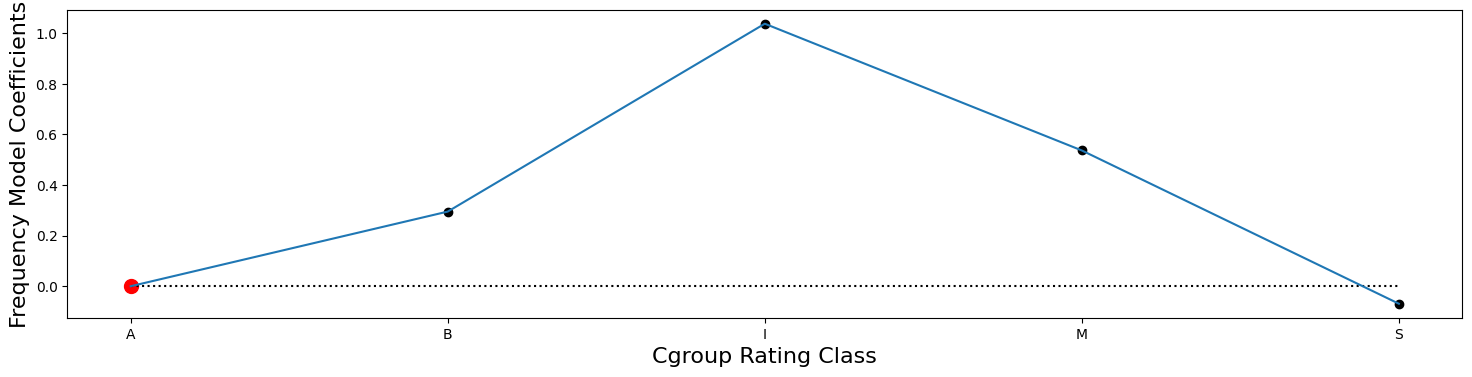

In [33]:
fig = plt.figure( figsize=(18,4) )

_coef = [0.0] + list(model_frequency.coef_[0:4])  


dx = np.sort(df.cgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.cgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.cgroup.unique())[0], _coef[0], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
# plt.ylim(-0.2, 1.0)
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

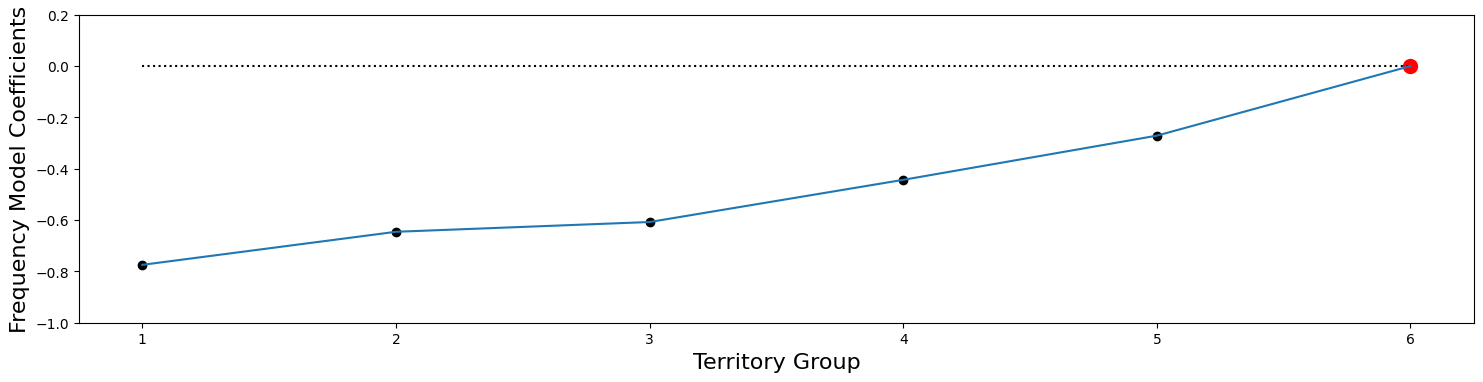

In [34]:
fig = plt.figure( figsize=(18,4) )

_coef = list(model_frequency.coef_[4:9]) + [0.0]


dx = np.sort(df.tgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.tgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.tgroup.unique())[5], _coef[5], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
plt.ylim(-1.0, 0.2)
plt.xlabel('Territory Group', fontdict={'size':16})
plt.ylabel('Frequency Model Coefficients', fontdict={'size':16})


plt.show()

Estimate Claim Frequency 

In [36]:
key = np.array(
    ['intercept', 
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5'])

val = [model_frequency.intercept_] + [0.0] + list(model_frequency.coef_)[0:4] 
val = val +  [0.0] + list(model_frequency.coef_)[4:]
val = np.array([round(x,8) for x in val])

rel = np.array([ round(np.exp(x),8) for x in val]) 

In [39]:
_xc = pd.get_dummies( XC, drop_first=False )
_bf = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [40]:
_bf

,Feature,Estimate,Relativity
0,intercept,-2.62808037,0.07221696
1,cgroup_A,0.0,1.0
2,cgroup_B,0.29493307,1.34303647
3,cgroup_I,1.03717911,2.82124735
4,cgroup_M,0.53640626,1.70985105
5,cgroup_S,-0.0691466,0.93318986
6,tgroup_6,0.0,1.0
7,tgroup_1,-0.77445497,0.46095495
8,tgroup_2,-0.64571186,0.52428919
9,tgroup_3,-0.60764444,0.54463227


In [41]:
def calcFrequency(data, coef, exposure):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    f = []
    for i in range(D.shape[0]):
        
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        f.append( m*np.exp(b0) )
        
    return np.array( exposure*f )

Claim Frequency

In [42]:
_ee = np.exp( np.zeros( len(df.EarnExpo.values)) )

calc_pred_f = calcFrequency(_xc,_bf,_ee)
q = np.quantile( calc_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[0.031065, 0.037863, 0.046357, 0.055065, 0.203742]

Claim Count

In [43]:
_ee = np.exp( np.log(df.EarnExpo.values) )

calc_count = calcFrequency(_xc,_bf,_ee)

q = np.quantile( calc_count, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[0.002589, 0.033289, 0.039332, 0.054922, 0.407484]

Plot Estimated Frequency 

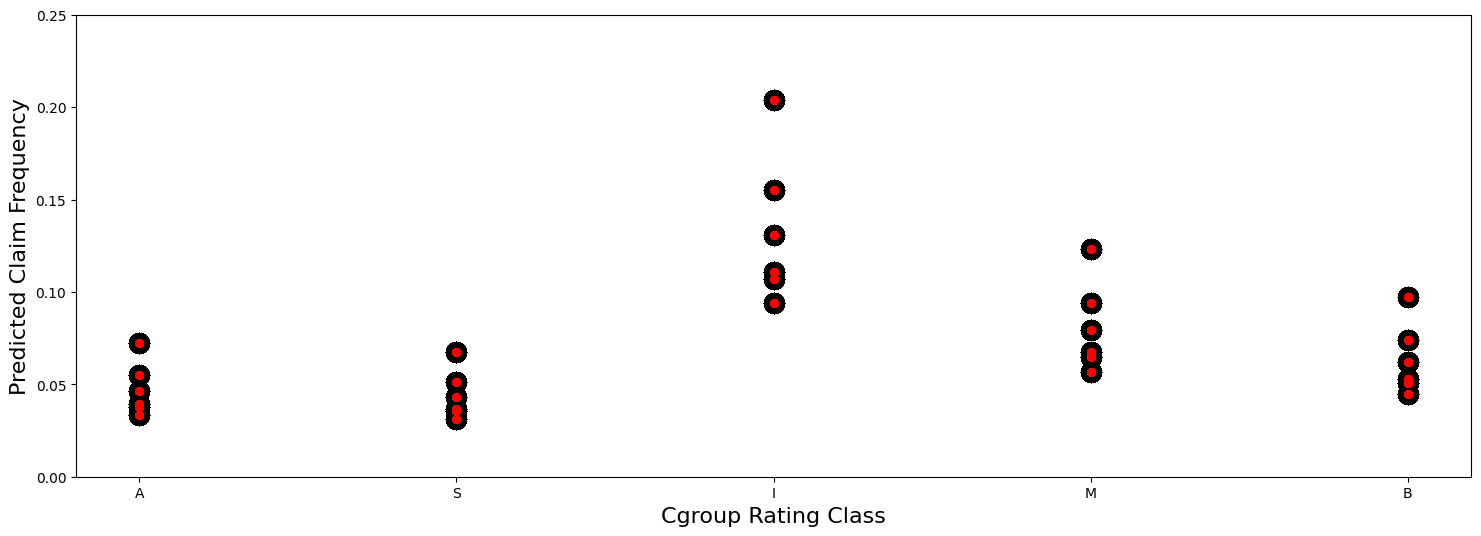

In [44]:
fig = plt.figure( figsize=(18,6) )


# Model Prediction
fx = df.cgroup.to_numpy()
fy = y_pred_f 
plt.scatter( fx, fy, s=200, color='black' )


def changeLabels(x):
    if x=='A':
        x=0
    elif x=='B':
        x=4
    elif x=='I':
        x=2
    elif x=='M':
        x=3
    else:
        x=1 
    return x

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:orange', linestyle='dotted', linewidth=6)
plt.ylim(0,0.25)



# Estimate from Coefficients
fx = df.cgroup.to_numpy()
fy = calc_pred_f 
plt.scatter( fx, fy, s=25, color='red' )

# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:blue', linestyle='dotted', linewidth=6)
plt.ylim(0,0.25)


# plt.xticks( np.sort(np.unique(fx)) )
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Predicted Claim Frequency', fontdict={'size':16})


plt.show()

### Model 2 : Claim Severity

Get X,y

In [45]:
df1 = df[ df.TotLoss > 0 ]

In [46]:
pos_loss_ind = df1.index.to_list()

In [47]:
_XC_ = XC.loc[pos_loss_ind, :]

In [48]:
X = pd.get_dummies( _XC_, drop_first=True)

In [49]:
y = df1.TotLoss.to_numpy()/df1.ClaimNum.to_numpy()

In [50]:
print('y min  :', y.min())
print('y max  :', y.max())
print('')
print('y mean :', np.mean(y) )
print('y stdev:', np.std(y) )

y min  : 50.0
y max  : 43000.0

y mean : 2942.9714747474745
y stdev: 4534.75573108117


Plot y

In [51]:
# fig, ax = plt.subplots(1,1, figsize=(16,5))
# ax.hist( y, bins=101  )
# plt.show()

Get weights

In [52]:
weights = df1.ClaimNum.to_numpy()

Build model

In [53]:
from sklearn import linear_model

model_severity = linear_model.GammaRegressor(alpha=0.0, fit_intercept=True)

model_severity.fit(X, y, sample_weight=weights)

GammaRegressor(alpha=0.0)

In [54]:
model_severity.score(X, y)

0.005550356101304055

Average Loss Prediction

In [55]:
y_pred_s = model_severity.predict(X)
y_pred_s[0:5]

array([2940.16784342, 2979.68572252, 3017.00989623, 2563.23327209,
       2940.16784342])

Summary Statistics of Average Loss Prediction

In [56]:
np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )

array([2531.52288094, 2853.8926651 , 2949.56221165, 3017.00989623,
       3765.7444205 ])

Total Loss Prediction

In [57]:
pred_loss = weights * y_pred_s
pred_loss[0:5]

array([2940.16784342, 2979.68572252, 3017.00989623, 2563.23327209,
       2940.16784342])

In [58]:
np.quantile( pred_loss, q=(0.0,0.25,0.50,0.75,1.0) )

array([ 2531.52288094,  2853.8926651 ,  2949.56221165,  3017.00989623,
       11044.67451893])

In [59]:
print( 'actual claim amount    :', df.TotLoss.sum() )
print( 'predicted claim amount :', round(sum(pred_loss),2) )

actual claim amount    : 12747526.0
predicted claim amount : 12748173.85


Plot Model Coefficients

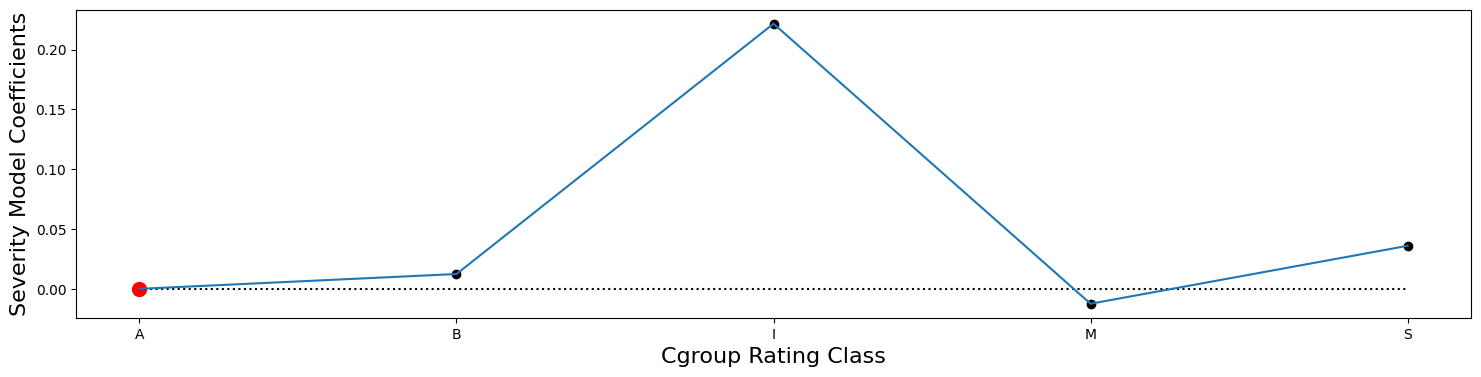

In [62]:
fig = plt.figure( figsize=(18,4) )

_coef = [0.0] + list(model_severity.coef_[0:4])  


dx = np.sort(df.cgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.cgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.cgroup.unique())[0], _coef[0], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Severity Model Coefficients', fontdict={'size':16})


plt.show()

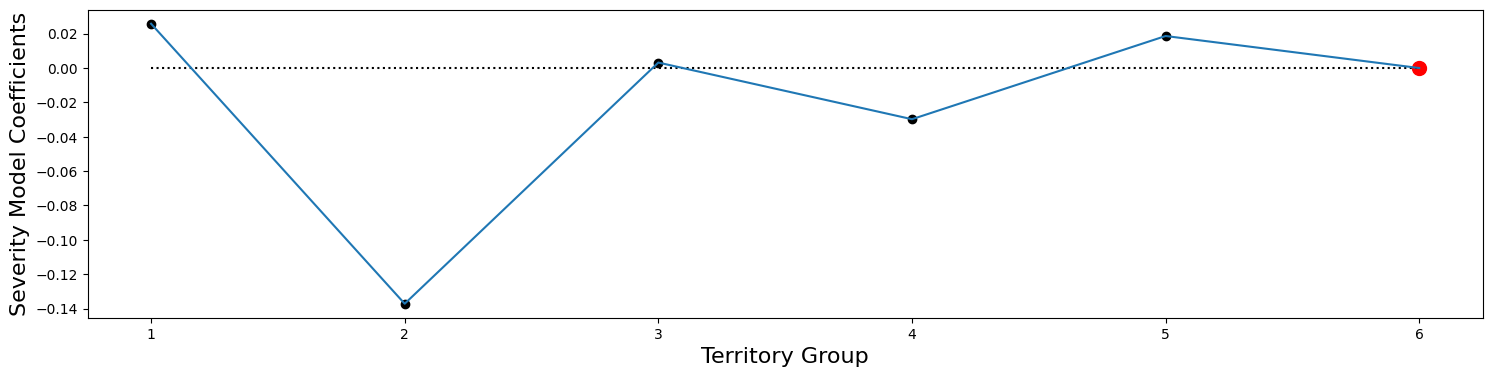

In [63]:
fig = plt.figure( figsize=(18,4) )

_coef = list(model_severity.coef_[4:9]) + [0.0]


dx = np.sort(df.tgroup.unique())
dy =  np.zeros( len(dx) )
plt.plot(dx, dy, color='black', linestyle='dotted')

plt.scatter( np.sort(df.tgroup.unique()), _coef, color='black')
plt.scatter( np.sort(df.tgroup.unique())[5], _coef[5], s=100, color='red')
plt.plot(dx, _coef)


plt.xticks(dx)
# plt.ylim(-1.0, 0.2)
plt.xlabel('Territory Group', fontdict={'size':16})
plt.ylabel('Severity Model Coefficients', fontdict={'size':16})


plt.show()

In [64]:
# fig = plt.figure( figsize=(18,4) )

# _coef = [0.0] + list(model_severity.coef_[9:])  


# dx = np.sort(df.rateclass.unique())
# dy =  np.zeros( len(dx) )
# plt.plot(dx, dy, color='black', linestyle='dotted')

# plt.scatter( np.sort(df.rateclass.unique()), _coef, color='black')
# plt.scatter( np.sort(df.rateclass.unique())[0], _coef[0], s=100, color='red')
# plt.plot(dx, _coef)


# plt.xticks(dx)
# plt.xlabel('Rating Class', fontdict={'size':16})
# plt.ylabel('Severity Model Coefficients', fontdict={'size':16})


# plt.show()

Estimate Claim Severity

In [65]:
key = np.array(
    ['intercept', 
     'cgroup_A','cgroup_B','cgroup_I','cgroup_M','cgroup_S',
     'tgroup_6','tgroup_1','tgroup_2','tgroup_3','tgroup_4','tgroup_5'])

val = [model_severity.intercept_] + [0.0] + list(model_severity.coef_)[0:4] 
val = val + [0.0] + list(model_severity.coef_)[4:]
val = np.array([round(x,8) for x in val])

rel = np.array([ round(np.exp(x),8) for x in val]) 

In [67]:
_xc = pd.get_dummies( _XC_, drop_first=False )
_bs = pd.DataFrame( np.column_stack((key,val,rel)), columns=['Feature','Estimate','Relativity'])

In [68]:
_bs

,Feature,Estimate,Relativity
0,intercept,7.98622195,2940.16784841
1,cgroup_A,0.0,1.0
2,cgroup_B,0.01238593,1.01246295
3,cgroup_I,0.22167932,1.24817105
4,cgroup_M,-0.01244841,0.98762875
5,cgroup_S,0.03598362,1.03663887
6,tgroup_6,0.0,1.0
7,tgroup_1,0.02579957,1.02613526
8,tgroup_2,-0.13719721,0.87179828
9,tgroup_3,0.00319009,1.00319518


In [69]:
def calcSeverity(data, coef, claimnumber):
    
    D = data.values
    
    if coef['Estimate'].dtype=='object':
        b = coef['Estimate'].astype('float64').to_numpy()
    
    b0 = b[0]
    b1 = b[1:]
    
    s = []
    for i in range(D.shape[0]):
        
        m = 1
        for j in range(len(b1)): 
            m *= np.exp(D[i,j] * b1[j])
            
        s.append( m*np.exp(b0) )
        
    return np.array(  claimnumber*s )

Average Severity

In [70]:
_cn = np.exp( np.zeros(len(df1.ClaimNum.values)) )

calc_pred_s = calcSeverity(_xc,_bs,_cn)

q = np.quantile( calc_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[2531.522881, 2853.892669, 2949.562225, 3017.009898, 3765.744413]

Total Loss

In [71]:
_cn = np.exp( np.log(df1.ClaimNum.values) )

calc_loss = calcSeverity(_xc,_bs,_cn)

q = np.quantile( calc_loss, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,6) for x in q]

[2531.522881, 2853.892669, 2949.562225, 3017.009898, 11044.67454]

Plot Estimated Severity

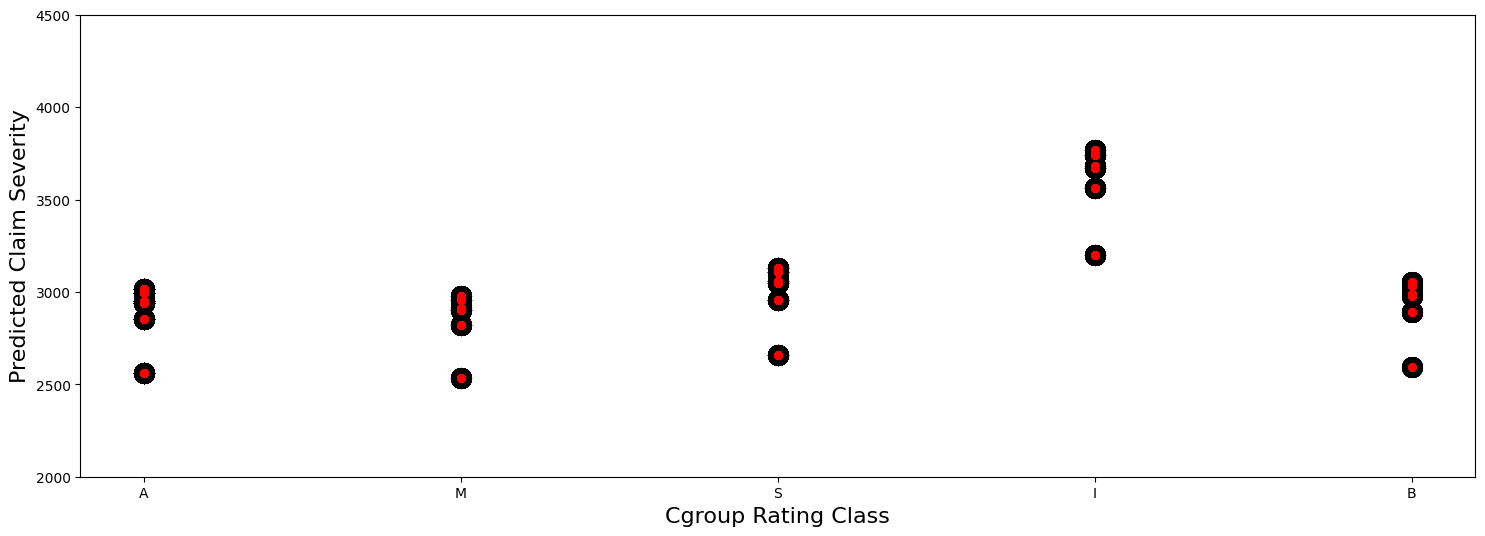

In [72]:
fig = plt.figure( figsize=(18,6) )


# Model Prediction
fx = df1.cgroup.to_numpy()
fy = y_pred_s
plt.scatter( fx, fy, s=200, color='black' )


# def changeLabels(x):
#     if x=='A':
#         x=0
#     elif x=='B':
#         x=4
#     elif x=='I':
#         x=3
#     elif x=='M':
#         x=1
#     else:
#         x=2 
#     return x

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:orange', linestyle='dotted', linewidth=6)
plt.ylim(2000,4500)


# Estimate from Model Coefficients
fx = df1.cgroup.to_numpy()
fy = calc_pred_s
plt.scatter( fx, fy, s=25, color='red' )

# tmp = pd.DataFrame({'x':fx, 'y':fy})
# tmp['labels'] = tmp.apply( lambda r : changeLabels(r.x), axis=1)
# tmp = tmp.sort_values(by=['labels']).reset_index(drop=False)
# plt.plot(tmp.labels, fy, color='tab:blue', linestyle='dotted', linewidth=6)
plt.ylim(2000,4500)


# plt.xticks( np.sort(np.unique(fx)) )
plt.xlabel('Cgroup Rating Class', fontdict={'size':16})
plt.ylabel('Predicted Claim Severity', fontdict={'size':16})


plt.show()

-------------------------------------------------------------------------------------------------

#### Pure Premium on Positive Loss Dataset

In [73]:
# Model Prediction  1
pure_premium_exp = y_pred_f[pos_loss_ind] * y_pred_s
q = np.quantile( pure_premium_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

[93.8849, 100.4325, 132.2984, 212.33, 747.6986]

In [74]:
# Model Prediction 2
pure_premium_exp = calc_pred_f[pos_loss_ind] * calc_pred_s
q = np.quantile( pure_premium_exp, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

[93.8849, 100.4325, 132.2984, 212.33, 747.6986]

In [75]:
# Observed Data
tot_loss_act  = df1.TotLoss.sum()
print('total loss actual    :', round(tot_loss_act,4))

pure_premium_act = df1.TotLoss/df1.EarnExpo
print('pure premium actual  :', round(sum(pure_premium_act),4))

q = np.quantile( pure_premium_act, q=(0.0,0.25,0.50,0.75,1.0) )
[round(x,4) for x in q]

total loss actual    : 12747526.0
pure premium actual  : 15220807.2903


[50.0, 708.0, 1514.0, 3475.0, 153792.0006]

#### Pure Premium for the Entire Dataset

Actual Loss

In [76]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 12747526.0


Expected Loss = Loss Cost = Pure Premium

In [77]:
X = pd.get_dummies(XC, drop_first=True)

y_pred_s = model_severity.predict(X)

print('Predicted Severity by Row :', [round(x,4) for x in y_pred_s[0:5]])
print('Predicted Total Severity  :', np.sum(y_pred_s))

Predicted Severity by Row : [2995.5084, 2853.8927, 2853.8927, 2949.5622, 2853.8927]
Predicted Total Severity  : 291260884.57169586


In [78]:
"""Expected Total Loss from Claim Severity"""
loss_expected_s =  y_pred_s * df.ClaimNum
loss_expected_s.sum()

12748173.848228969

In [79]:
pure_premium = y_pred_f * y_pred_s

print('Pure Premium :', [round(x,4) for x in pure_premium[0:5]], '\n')

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Pure Premium : [164.9471, 132.2984, 132.2984, 116.0113, 132.2984] 

Pure Premium Quartile : [93.8849, 100.4325, 132.2984, 164.9471, 747.6986]


In [80]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Loss :', round(loss_expected,4) )

Expected Loss : 12749876.6962


#### Model Performance on Training  Data 

Example : A/E for Entire Dataset

In [81]:
A_by_E = loss_actual/loss_expected
A_by_E

0.9998156298853285

Example : Loss A/E (Data is Grouped by Variables)

In [82]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [83]:
grp1 = tmp.groupby(by=['cgroup'], as_index=True)
res1 = grp1.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp2 = tmp.groupby(by=['tgroup'], as_index=True)
res2 = grp2.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp3 = tmp.groupby(by=['rateclass'], as_index=True)
res3 = grp3.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })


y_driver_age =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_driver_age =list(res1.index)

y_vehicle_age =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_vehicle_age =list(res2.index)

y_license_year =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_license_year =list(res3.index)

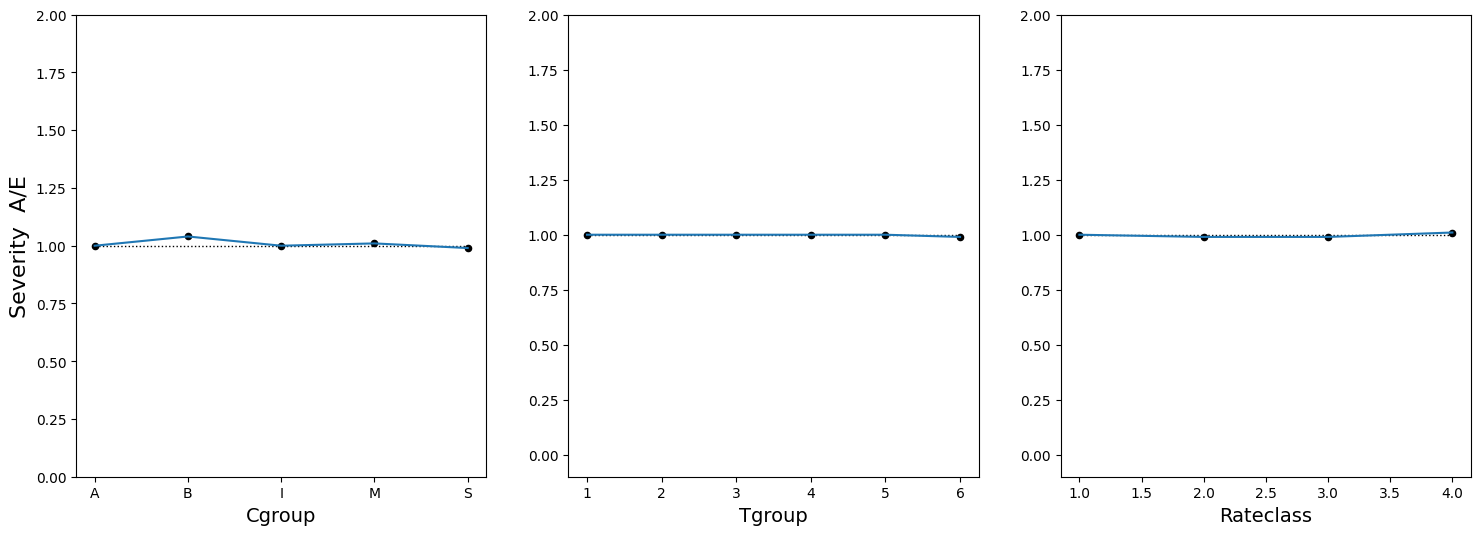

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Severity  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_license_year
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
ax[2].plot(x_license_year, y_license_year, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [85]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

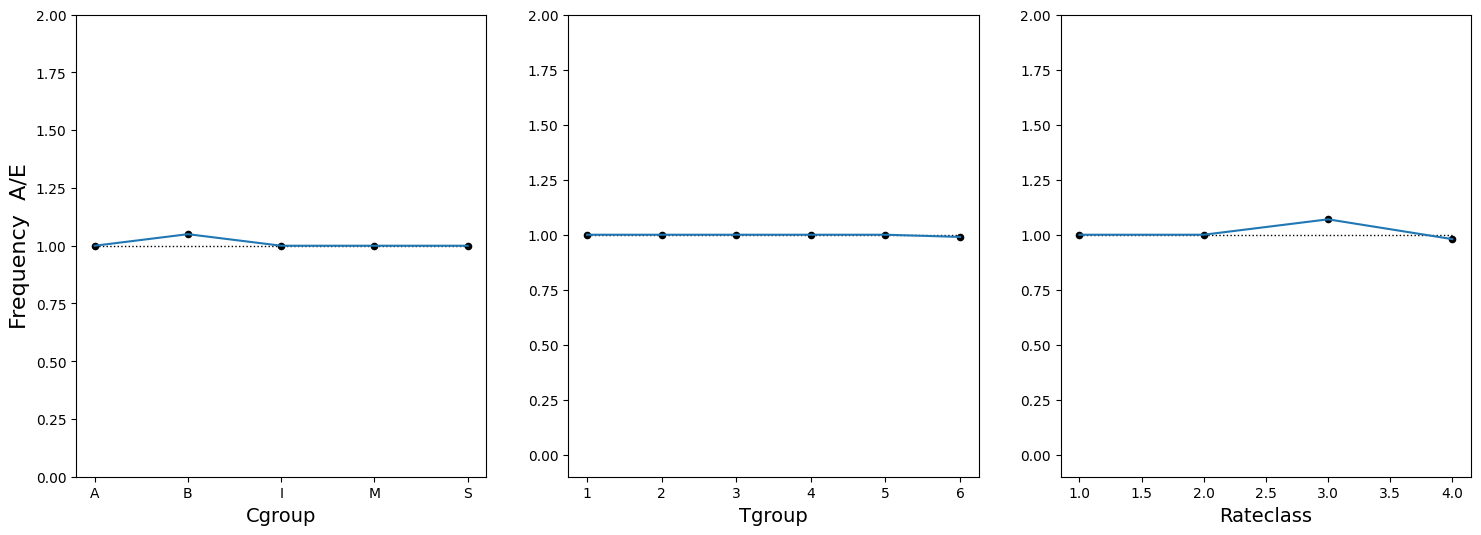

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_rateclass
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [87]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [88]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

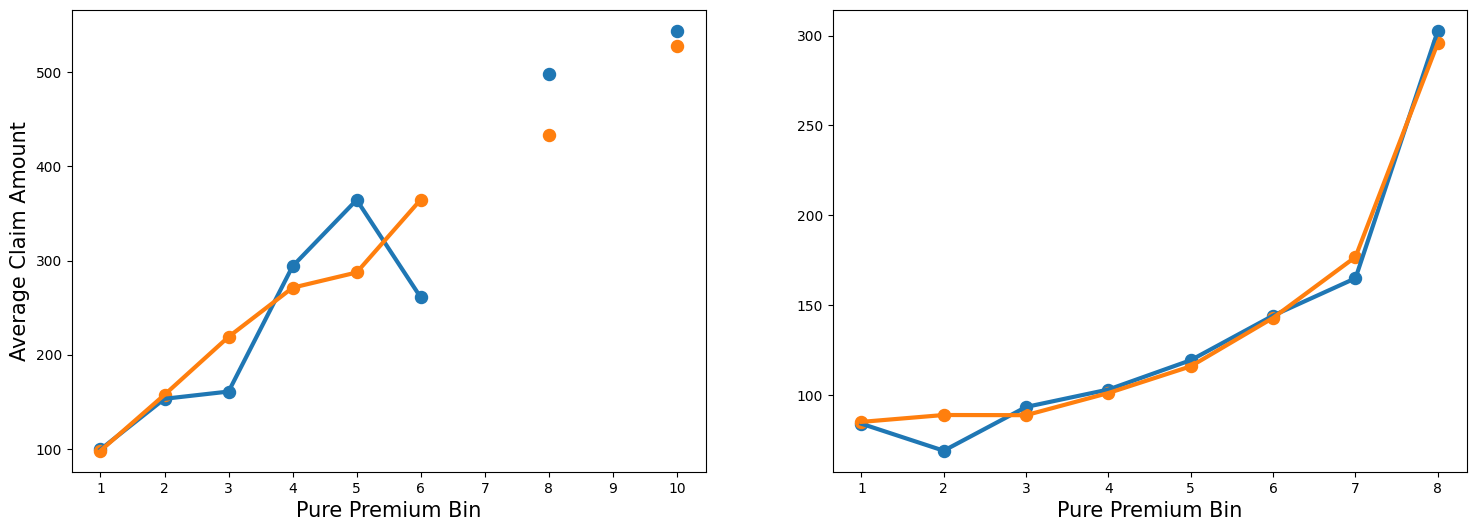

In [89]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

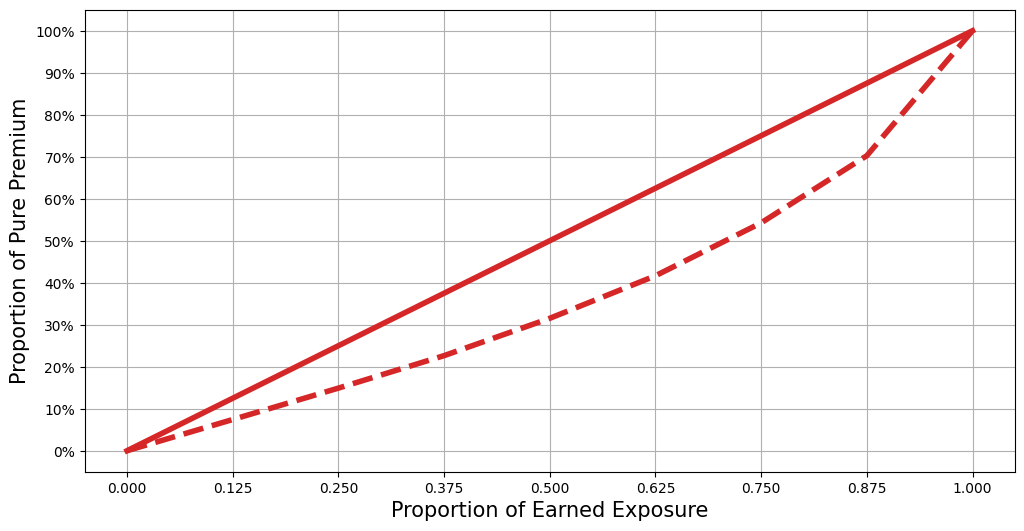

In [90]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

Calculate Gini Index

In [91]:
def gini_index(xp,yp,delta):
    
    dln = len(xp)
    
    if any(yp > 1.0):
        yp = yp/100.
    else:
        yp = yp

    x  = np.arange(0,1,delta)
    y  = np.interp(x, xp, yp)

    area_b = np.trapz(y, x)
    area_a = 0.5-area_b
    
    gini_index = area_a/(area_a+area_b)
    
    return  gini_index

In [92]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.28807959983397324

-------------------------------------------------------------------------------------------------

## Part 2 : Validation Data

In [93]:
data = pd.read_csv('data_purepremium_valid.csv')
df = data[['ann_miles','cgroup','tgroup','rateclass','TotLoss','ClaimNum','EarnExpo']]

Check Agrregate Risks  

In [94]:
print( 'Claim Frequency :', round(data.ClaimNum.sum()/data.EarnExpo.sum(),4) ) 
print( 'Claim Severity  :', round(data.TotLoss.sum()/data.ClaimNum.sum(),2) ) 
print( 'Pure Premium    :', round( data.TotLoss.sum()/data.EarnExpo.sum(),2) ) 

Claim Frequency : 0.0496
Claim Severity  : 2815.89
Pure Premium    : 139.56


In [95]:
# _cgroup = pd.CategoricalIndex(df.cgroup, ordered=True, categories=['A', 'B', 'I', 'M', 'S'])
# a =_cgroup.to_frame()
# a = a.reset_index(drop=True)

In [96]:
# _tgroup = pd.CategoricalIndex(df.tgroup, ordered=True, categories=[6, 1, 2, 3, 4, 5])
# b =_tgroup.to_frame()
# b = b.reset_index(drop=True)

In [97]:
# _rateclass = pd.CategoricalIndex(df.rateclass, ordered=True, categories=[1, 2, 3, 4])
# c =_rateclass.to_frame()
# c = c.reset_index(drop=True)

Categorical Data

In [98]:
_x1 = relevel(df, 'cgroup', 'A')
_x2 = relevel(df, 'tgroup', 6)
_x3 = relevel(df, 'rateclass', 1)

In [99]:
XC = pd.concat([_x1,_x2], axis=1)

Get X

In [100]:
X = pd.get_dummies( XC, drop_first=True)

Claim Frequency Prediction

In [101]:
y_pred_f = model_frequency.predict(X)
y_pred_f[0:5]

array([0.03328876, 0.03786257, 0.03670393, 0.03786257, 0.03533297])

Summary Statistics of Claim Frequency Prediction

In [102]:
np.quantile( y_pred_f, q=(0.0,0.25,0.50,0.75,1.0) )

array([0.03106474, 0.03786257, 0.04635717, 0.05506482, 0.2037419 ])

Claim Severity Prediction

In [103]:
y_pred_s = model_severity.predict(X)
y_pred_s[0:5]

array([3017.00989623, 2563.23327209, 3057.63083888, 2563.23327209,
       2657.14724342])

Summary Statistics of Claim Severity Prediction

In [104]:
np.quantile( y_pred_s, q=(0.0,0.25,0.50,0.75,1.0) )

array([2531.52288094, 2853.8926651 , 2949.56221165, 3017.00989623,
       3765.7444205 ])

Actual Loss

In [105]:
loss_actual = df.TotLoss.sum()
print('Actual Loss :', round(loss_actual,4) )

Actual Loss : 6059796


Expected Loss

In [106]:
"""Expected Total Loss from Claim Severity"""
loss_expected_s =  y_pred_s * df.ClaimNum

print('Expected Loss :', round(loss_expected_s.sum(),4) )

Expected Loss : 6350782.6764


In [107]:
pure_premium = y_pred_f * y_pred_s

print('Pure Premium Values   :', [round(x,4) for x in pure_premium[0:5]], '\n')

q = np.quantile( pure_premium, q=(0.0,0.25,0.50,0.75,1.0) )
print('Pure Premium Quartile :', [round(x,4) for x in q] )

Pure Premium Values   : [100.4325, 97.0506, 112.2271, 97.0506, 93.8849] 

Pure Premium Quartile : [93.8849, 100.4325, 132.2984, 164.9471, 747.6986]


In [108]:
y_pred_l = pure_premium * df.EarnExpo.values
loss_expected = np.sum( y_pred_l )
print('Expected Loss :', round(loss_expected,4) )

Expected Loss : 6385618.514


#### Model Performance on Validation Data

Example : A/E for Entire Dataset

In [109]:
A_by_E = loss_actual/loss_expected
A_by_E

0.9489755748403489

Example : Loss A/E (Data is Grouped by Driver Age)

In [110]:
tmp = df.copy()
tmp['PredFrequency'] = y_pred_f
tmp['PredSeverity']  = y_pred_s
tmp['ExpectedLoss']  = y_pred_l

In [111]:
grp1 = tmp.groupby(by=['cgroup'], as_index=True)
res1 = grp1.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp2 = tmp.groupby(by=['tgroup'], as_index=True)
res2 = grp2.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })

grp3 = tmp.groupby(by=['rateclass'], as_index=True)
res3 = grp3.apply(lambda x : 
                {'A': sum(x.TotLoss), 
                 'E': sum(x.ExpectedLoss),
                 'AE':round(sum(x.TotLoss)/sum(x.ExpectedLoss),2)
                })


y_driver_age =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_driver_age =list(res1.index)

y_vehicle_age =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_vehicle_age =list(res2.index)

y_license_year =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_license_year =list(res3.index)

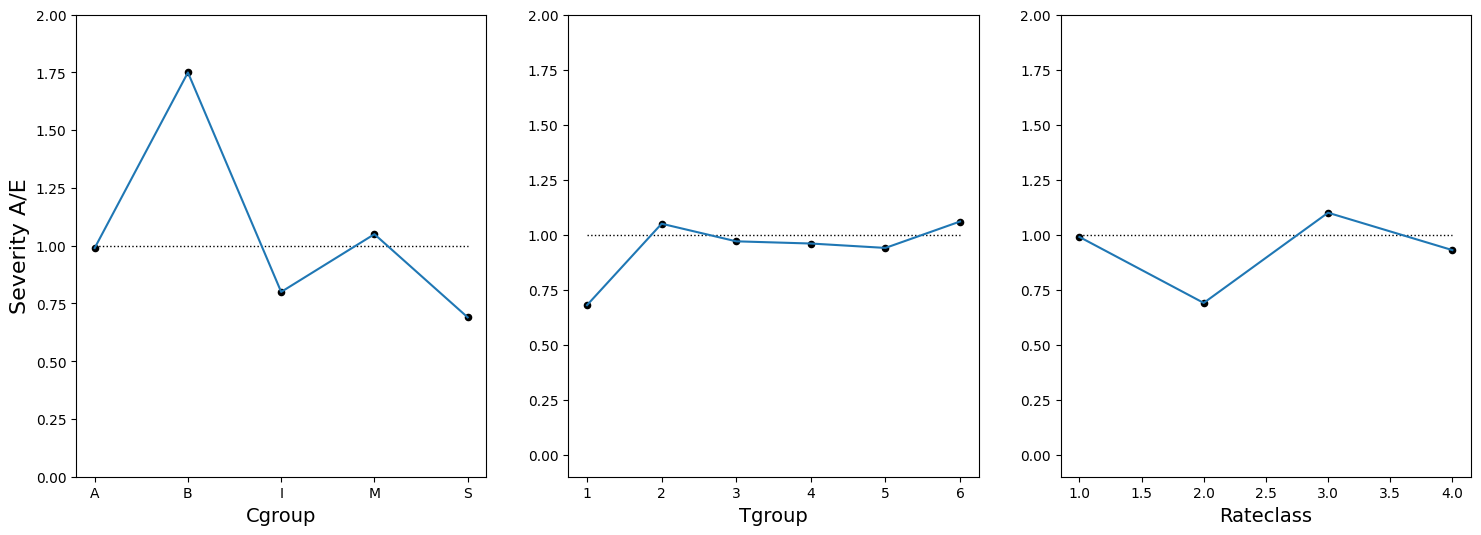

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_driver_age
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_driver_age, y_driver_age, s=20, color='black')
ax[0].plot(x_driver_age, y_driver_age, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Severity A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_vehicle_age
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_vehicle_age, y_vehicle_age, s=20, color='black')
ax[1].plot(x_vehicle_age, y_vehicle_age, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_license_year
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_license_year, y_license_year, s=20, color='black')
ax[2].plot(x_license_year, y_license_year, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Frequency A/E (Data is Grouped by Variables)

In [113]:
def frequency_A_by_E(data, feature):
    
    grp = data.groupby(by=[feature], as_index=True)
    
    res = grp.apply(lambda x : 
                {'A': x.ClaimNum.sum()/x.EarnExpo.sum(),         
                 'E': (x.PredFrequency*x.EarnExpo).sum()/x.EarnExpo.sum(),   
                 'AE':round(x.ClaimNum.sum()/(x.PredFrequency*x.EarnExpo).sum(),2)
                })
    return res


res1 = frequency_A_by_E(tmp, 'cgroup')
res2 = frequency_A_by_E(tmp, 'tgroup')
res3 = frequency_A_by_E(tmp, 'rateclass')
    
y_cgroup =[res1.values[x]['AE'] for x in range(res1.shape[0])]
x_cgroup =list(res1.index)

y_tgroup =[res2.values[x]['AE'] for x in range(res2.shape[0])]
x_tgroup =list(res2.index)

y_rateclass =[res3.values[x]['AE'] for x in range(res3.shape[0])]
x_rateclass =list(res3.index)

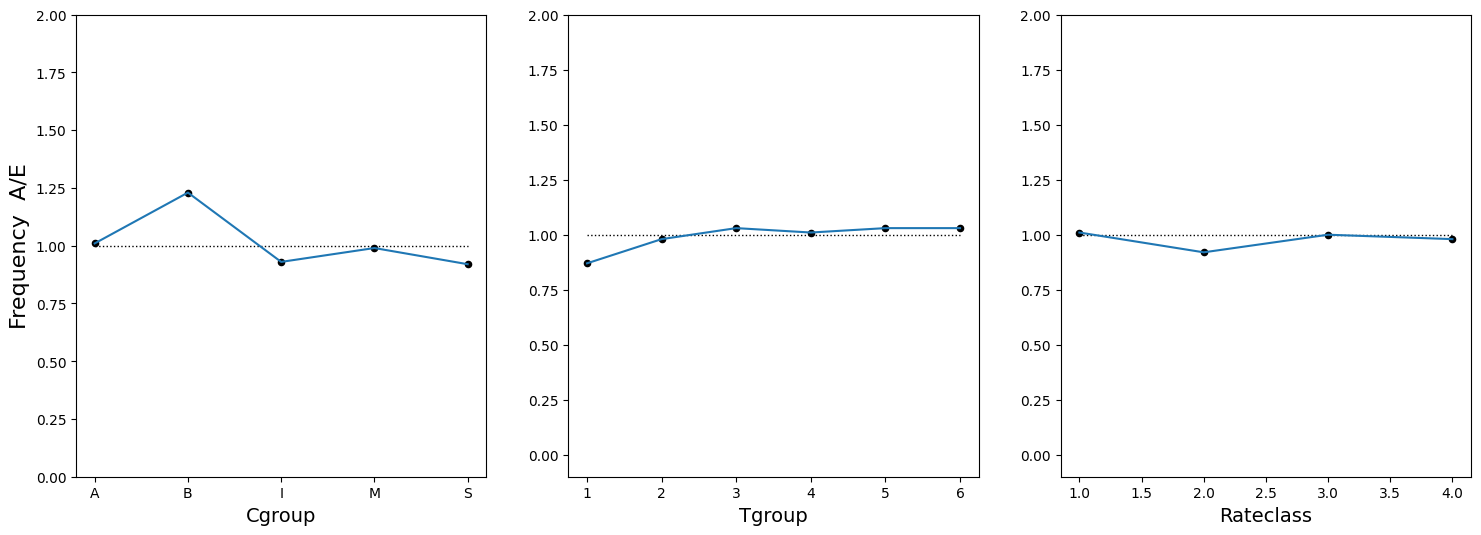

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

x = x_cgroup
y = np.ones( len(x) )
ax[0].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[0].scatter(x_cgroup, y_cgroup, s=20, color='black')
ax[0].plot(x_cgroup, y_cgroup, linestyle='solid')
ax[0].set_ylim(-0.,2)
ax[0].set_ylabel('Frequency  A/E', fontdict={'size':16})
ax[0].set_xlabel('Cgroup', fontdict={'size':14})

x = x_tgroup
y = np.ones( len(x) )
ax[1].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[1].scatter(x_tgroup, y_tgroup, s=20, color='black')
ax[1].plot(x_tgroup, y_tgroup, linestyle='solid')
ax[1].set_ylim(-0.1,2)
ax[1].set_xlabel('Tgroup', fontdict={'size':14})

x = x_rateclass
y = np.ones( len(x) )
ax[2].plot(x,y, color='black',linestyle='dotted', linewidth=1)
ax[2].scatter(x_rateclass, y_rateclass, s=20, color='black')
ax[2].plot(x_rateclass, y_rateclass, linestyle='solid')
ax[2].set_ylim(-0.1,2)
ax[2].set_xlabel('Rateclass', fontdict={'size':14})

plt.show()

Example : Pure Premium vs Average Claim Amount

In [115]:
obs_loss = df['TotLoss'].values
exposure = df['EarnExpo'].values
pure_prm = y_pred_f * y_pred_s
exp_loss = y_pred_l

tmp =  pd.DataFrame( 
    np.column_stack((obs_loss, exposure, pure_prm, exp_loss)), 
    columns=['Actual','Exposure','PurePremium','Expected'])

In [116]:
## General Equal-Width Bins
tmp1 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.cut( 
    tmp1.PurePremium.to_numpy(), 
    nbins,
    right=True, include_lowest=True, 
    ordered=True)

tmp1['ppGroups'] = ppBins

grp1 = tmp1.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean', 
     'ppGroups': 'count'
    })



## Quantile Equal-Frequency  Bins
tmp2 = tmp.sort_values(by=['PurePremium'], inplace=False).reset_index(drop=True)

nbins = 10
ppBins = pd.qcut( 
    tmp2.PurePremium.to_numpy(), 
    nbins,
    duplicates = 'drop')

tmp2['ppGroups'] = ppBins

grp2 = tmp2.groupby(by=['ppGroups'], as_index=False).agg(
    {'Actual':'mean', 
     'Exposure':'sum', 
     'PurePremium':'mean', 
     'Expected': 'mean',
     'ppGroups': 'count'
    })

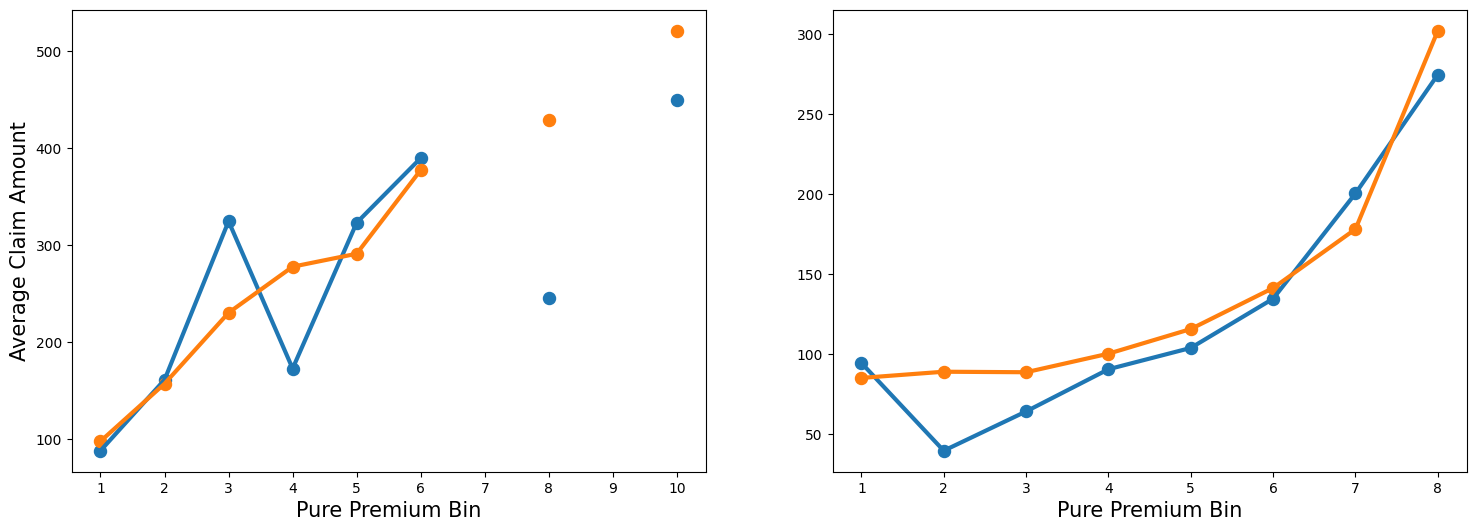

In [117]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

x1 = 1
x2 = grp1.shape[0]+1
ax[0].scatter( np.arange(x1,x2), grp1.Actual.to_list(), color='tab:blue', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Actual.to_numpy(), color='tab:blue', linewidth=3)
ax[0].scatter( np.arange(x1,x2),  grp1.Expected.to_numpy(), color='tab:orange', s=75)
ax[0].plot( np.arange(x1,x2), grp1.Expected.to_numpy(), color='tab:orange', linewidth=3)
ax[0].set_xticks(np.arange(x1,x2))
ax[0].set_xlabel('Pure Premium Bin', fontdict={'size':15})
ax[0].set_ylabel('Average Claim Amount', fontdict={'size':15})
#ax[0].text(1, 315, 'Equal-Width Bins', fontdict={'size':12})


x1 = 1
x2 = grp2.shape[0]+1
ax[1].scatter( np.arange(x1,x2), grp2.Actual.to_list(), color='tab:blue', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Actual.to_numpy(), color='tab:blue', linewidth=3)

ax[1].scatter( np.arange(x1,x2),  grp2.Expected.to_numpy(), color='tab:orange', s=75)
ax[1].plot( np.arange(x1,x2), grp2.Expected.to_numpy(), color='tab:orange', linewidth=3)

ax[1].set_xticks(np.arange(x1,x2))
ax[1].set_xlabel('Pure Premium Bin', fontdict={'size':15})
#ax[1].text(1, 120, 'Equal-Frequency Bins', fontdict={'size':12})

plt.show()

Example : Gini Index

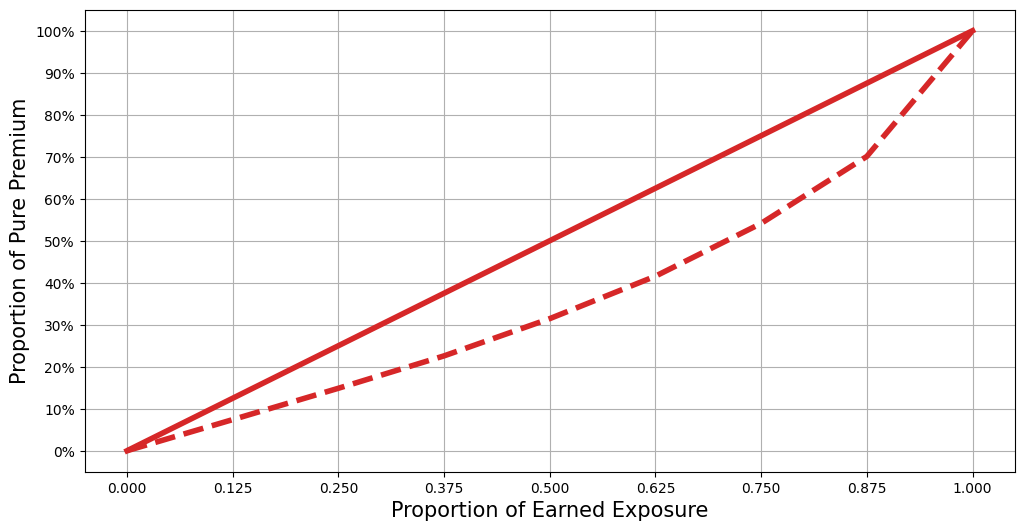

In [118]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

pp_frac = np.cumsum( grp2.PurePremium.to_numpy() )
pp_frac = pp_frac/pp_frac.max()
pp_frac = 100 * np.array( [0] + list(pp_frac) )


x1 = 0
x2 = grp2.shape[0]+1
x = np.arange(x1,x2)
x = x/x.max()
y = 100*x
ax.plot( x, y, color='tab:red', linewidth=4)


ax.plot( x, pp_frac, color='tab:red', linewidth=4, linestyle='dashed')
ax.set_xticks( x )

ax.set_xlabel('Proportion of Earned Exposure', fontdict={'size':15})
ax.set_ylabel('Proportion of Pure Premium', fontdict={'size':15})
ax.set_yticks( np.arange(0,101,10) )
ax.set_yticklabels( [str(x)+'%' for x in np.arange(0,101,10)] )
ax.grid(True)


plt.show()

In [119]:
xp = x
yp = pp_frac
delta = 0.01
gini_index(xp,yp,delta)

0.2895278808136881

## Check by Hand

In [120]:
_bf

,Feature,Estimate,Relativity
0,intercept,-2.62808037,0.07221696
1,cgroup_A,0.0,1.0
2,cgroup_B,0.29493307,1.34303647
3,cgroup_I,1.03717911,2.82124735
4,cgroup_M,0.53640626,1.70985105
5,cgroup_S,-0.0691466,0.93318986
6,tgroup_6,0.0,1.0
7,tgroup_1,-0.77445497,0.46095495
8,tgroup_2,-0.64571186,0.52428919
9,tgroup_3,-0.60764444,0.54463227


In [121]:
_bs

,Feature,Estimate,Relativity
0,intercept,7.98622195,2940.16784841
1,cgroup_A,0.0,1.0
2,cgroup_B,0.01238593,1.01246295
3,cgroup_I,0.22167932,1.24817105
4,cgroup_M,-0.01244841,0.98762875
5,cgroup_S,0.03598362,1.03663887
6,tgroup_6,0.0,1.0
7,tgroup_1,0.02579957,1.02613526
8,tgroup_2,-0.13719721,0.87179828
9,tgroup_3,0.00319009,1.00319518


In [122]:
XC.head()

,cgroup,tgroup
0,A,1
1,A,2
2,S,3
3,A,2
4,S,2


In [123]:
y_pred_f[0:3]

array([0.03328876, 0.03786257, 0.03670393])

In [124]:
y_pred_s[0:3]

array([3017.00989623, 2563.23327209, 3057.63083888])

In [125]:
pure_premium[0:3]

array([100.43253181,  97.05060107, 112.22707201])

Row 1

In [126]:
base_frequency         = 0.07221696
ratingclass_relativity = 1.0
territory_relativity   = 0.46095495

freq =  base_frequency * ratingclass_relativity * territory_relativity
freq

0.033288765185951995

In [127]:
base_severity          = 2940.16784841
ratingclass_relativity = 1.0
territory_relativity   = 1.02613526

severity =  base_severity * ratingclass_relativity * territory_relativity
severity

3017.009899571836

In [128]:
print( freq * severity )

100.43253411053945


Row 2

In [129]:
base_frequency         = 0.07221696
ratingclass_relativity = 1.0
territory_relativity   = 0.52428919

freq =  base_frequency * ratingclass_relativity * territory_relativity
freq

0.03786257146266239

In [130]:
base_severity          = 2940.16784841
ratingclass_relativity = 1.0
territory_relativity   = 0.87179828

severity =  base_severity * ratingclass_relativity * territory_relativity
severity

2563.2332731551387

In [131]:
print( freq * severity )

97.05060298031047


Row 3

In [132]:
base_frequency         = 0.07221696
ratingclass_relativity = 0.93318986
territory_relativity   = 0.54463227

freq =  base_frequency * ratingclass_relativity * territory_relativity
freq

0.036703931351926886

In [133]:
base_severity          = 2940.16784841
ratingclass_relativity = 1.03663887
territory_relativity   = 1.00319518

severity =  base_severity * ratingclass_relativity * territory_relativity
severity

3057.6308404284587

In [134]:
print( freq * severity )

112.22707246662065
